# Cervical Cancer Cell Classification Pipeline
## Project Phoenix - Herlev Dataset Analysis

This notebook implements a complete classification pipeline:
1. Data Loading and Preparation
2. Baseline Model Evaluation (VGG, DenseNet, ResNet)
3. Hybrid Model Implementation (ResNet50 + Logistic Classifier)
4. Final Evaluation and Comparison
5. SHAP Explainability
6. Streamlit Dashboard Export

## 1. Setup and Imports

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision scikit-learn shap streamlit matplotlib seaborn pillow tqdm

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using device: cuda


## 2. Configuration

In [3]:
# Dataset configuration
DATA_PATH = "/content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Herlev Dataset/Preprocessing Analysis v3.0"
TRAIN_PATH = os.path.join(DATA_PATH, "train/processed_full")
TEST_PATH = os.path.join(DATA_PATH, "test/processed_full")

# Model configuration
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_CLASSES = 7

# Class names (Herlev dataset 7 classes)
CLASS_NAMES = [
    'carcinoma_in_situ',
    'light_dysplastic',
    'moderate_dysplastic',
    'normal_columnar',
    'normal_intermediate',
    'normal_superficial',
    'severe_dysplastic'
]

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Number of classes: 7
Classes: ['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar', 'normal_intermediate', 'normal_superficial', 'severe_dysplastic']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Data Loading and Preparation

In [5]:
class HerlevDataset(Dataset):
    """Custom Dataset for Herlev cervical cell images."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(root_dir)))}

        # Load all image paths and labels
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

        print(f"Loaded {len(self.images)} images from {root_dir}")
        print(f"Class mapping: {self.class_to_idx}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = HerlevDataset(TRAIN_PATH, transform=train_transform)
test_dataset = HerlevDataset(TEST_PATH, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loaded 643 images from /content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Herlev Dataset/Preprocessing Analysis v3.0/train/processed_full
Class mapping: {'carcinoma_in_situ': 0, 'light_dysplastic': 1, 'moderate_dysplastic': 2, 'normal_columnar': 3, 'normal_intermediate': 4, 'normal_superficiel': 5, 'severe_dysplastic': 6}
Loaded 274 images from /content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Herlev Dataset/Preprocessing Analysis v3.0/test/processed_full
Class mapping: {'carcinoma_in_situ': 0, 'light_dysplastic': 1, 'moderate_dysplastic': 2, 'normal_columnar': 3, 'normal_intermediate': 4, 'normal_superficiel': 5, 'severe_dysplastic': 6}

Train samples: 643
Test samples: 274


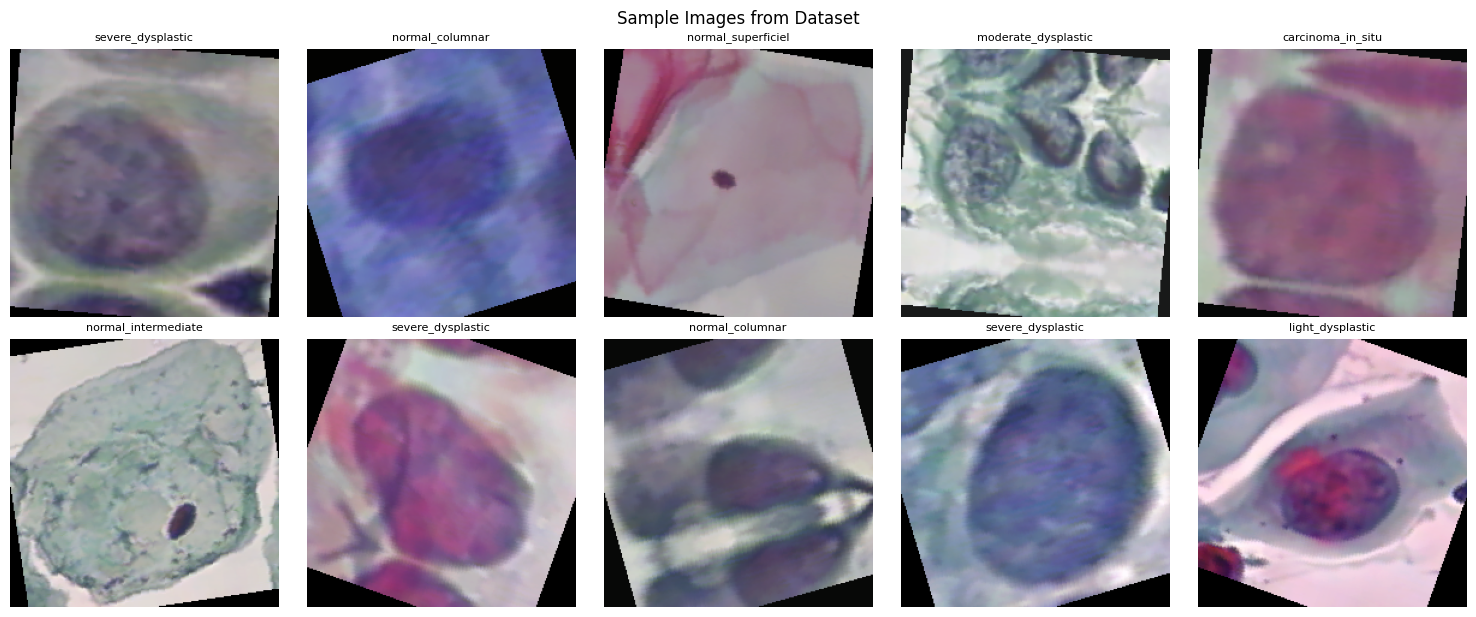

In [7]:
# Visualize sample images
def visualize_samples(dataset, num_samples=10):
    """Display sample images from the dataset."""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Get class names from dataset
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        # Denormalize for visualization
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(idx_to_class[label], fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Sample Images from Dataset', y=1.02)
    plt.show()

visualize_samples(train_dataset)

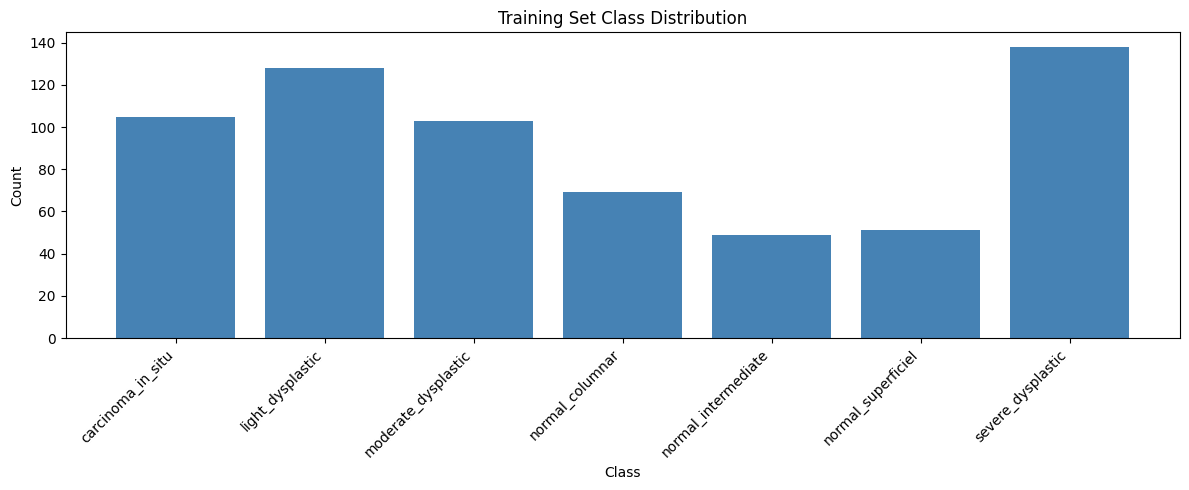

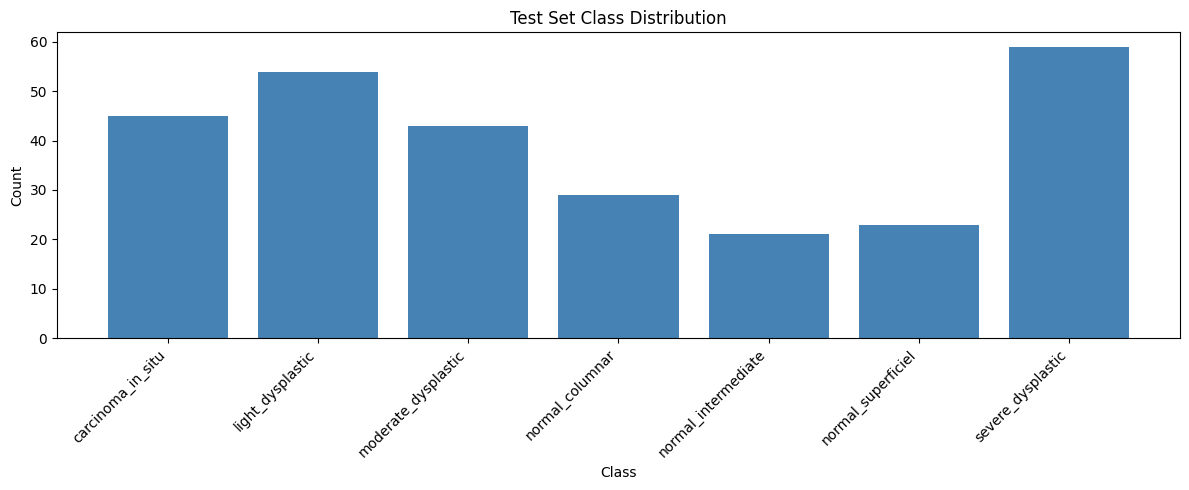

In [8]:
# Class distribution visualization
def plot_class_distribution(dataset, title="Class Distribution"):
    """Plot the distribution of classes in the dataset."""
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    class_counts = {}

    for label in dataset.labels:
        class_name = idx_to_class[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    plt.figure(figsize=(12, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return class_counts

train_distribution = plot_class_distribution(train_dataset, "Training Set Class Distribution")
test_distribution = plot_class_distribution(test_dataset, "Test Set Class Distribution")

## 4. Baseline Model Evaluation

We'll evaluate multiple pre-trained CNN architectures:
- VGG16
- DenseNet121
- ResNet50

In [9]:
def create_model(model_name, num_classes, pretrained=True):
    """Create a pre-trained model with modified classifier for our task."""

    if model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model.to(device)

In [10]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate):
    """Train a model and return training history."""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss = test_loss / test_total
        test_acc = test_correct / test_total

        scheduler.step(test_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc

    return history, best_acc

In [11]:
def evaluate_model(model, test_loader):
    """Evaluate model and return predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

In [12]:
def plot_training_history(history, model_name):
    """Plot training and validation curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} - Accuracy Curves')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Training VGG16
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 182MB/s]
Epoch 1/20: 100%|██████████| 21/21 [01:34<00:00,  4.52s/it]


Epoch 1: Train Loss=2.2158, Train Acc=0.1913, Test Loss=1.9065, Test Acc=0.1971


Epoch 2/20: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 2: Train Loss=1.9290, Train Acc=0.1835, Test Loss=1.8858, Test Acc=0.2153


Epoch 3/20: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 3: Train Loss=2.0766, Train Acc=0.1820, Test Loss=1.9364, Test Acc=0.1569


Epoch 4/20: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 4: Train Loss=1.9552, Train Acc=0.1820, Test Loss=1.9014, Test Acc=0.0620


Epoch 5/20: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch 5: Train Loss=1.8925, Train Acc=0.2100, Test Loss=1.8971, Test Acc=0.1971


Epoch 6/20: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 6: Train Loss=1.8969, Train Acc=0.1804, Test Loss=1.8806, Test Acc=0.1496


Epoch 7/20: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 7: Train Loss=1.8842, Train Acc=0.2115, Test Loss=1.8902, Test Acc=0.1277


Epoch 8/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 8: Train Loss=1.8800, Train Acc=0.2068, Test Loss=2.1569, Test Acc=0.2190


Epoch 9/20: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Epoch 9: Train Loss=1.8797, Train Acc=0.1944, Test Loss=1.9520, Test Acc=0.1825


Epoch 10/20: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Epoch 10: Train Loss=1.8074, Train Acc=0.2659, Test Loss=2.1744, Test Acc=0.1533


Epoch 11/20: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 11: Train Loss=1.7872, Train Acc=0.2473, Test Loss=1.6637, Test Acc=0.2993


Epoch 12/20: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 12: Train Loss=1.6467, Train Acc=0.3033, Test Loss=1.6543, Test Acc=0.2810


Epoch 13/20: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 13: Train Loss=1.5937, Train Acc=0.3142, Test Loss=1.6401, Test Acc=0.3102


Epoch 14/20: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 14: Train Loss=1.6377, Train Acc=0.2862, Test Loss=1.6852, Test Acc=0.2701


Epoch 15/20: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 15: Train Loss=1.5622, Train Acc=0.3219, Test Loss=1.6191, Test Acc=0.3358


Epoch 16/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 16: Train Loss=1.5772, Train Acc=0.2924, Test Loss=1.7441, Test Acc=0.2847


Epoch 17/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 17: Train Loss=1.5978, Train Acc=0.3157, Test Loss=1.5743, Test Acc=0.3613


Epoch 18/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 18: Train Loss=1.5317, Train Acc=0.3390, Test Loss=2.7644, Test Acc=0.2190


Epoch 19/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 19: Train Loss=1.6711, Train Acc=0.2986, Test Loss=1.6111, Test Acc=0.3723


Epoch 20/20: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 20: Train Loss=1.5142, Train Acc=0.3437, Test Loss=1.5352, Test Acc=0.3650


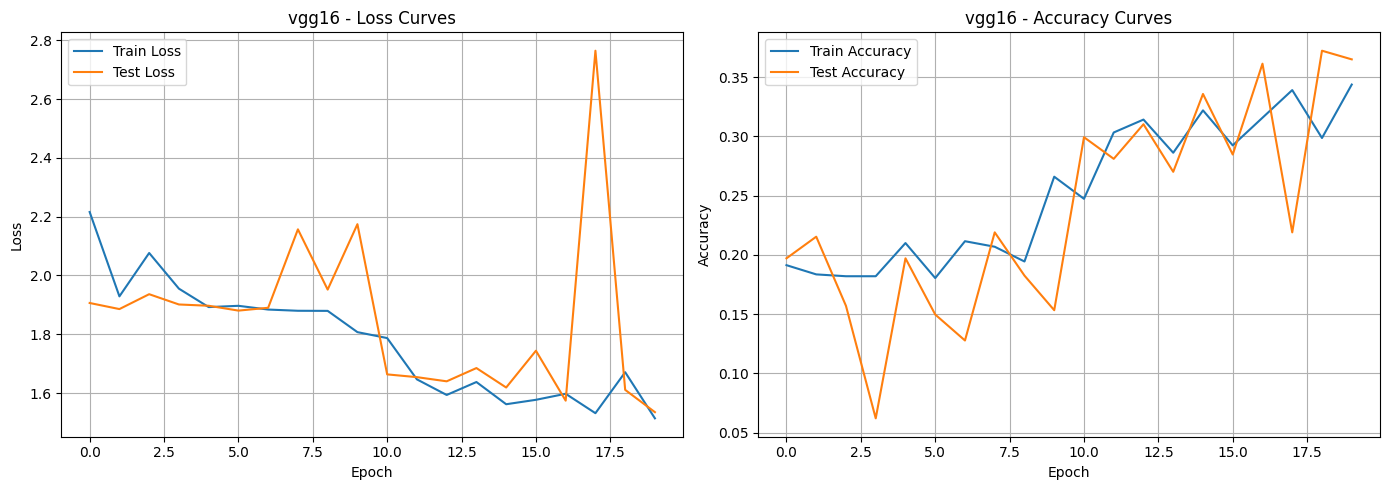


Classification Report for vgg16:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.00      0.00      0.00        45
   light_dysplastic       0.35      0.61      0.44        54
moderate_dysplastic       0.29      0.05      0.08        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       0.00      0.00      0.00        21
 normal_superficiel       0.56      0.83      0.67        23
  severe_dysplastic       0.33      0.78      0.47        59

           accuracy                           0.36       274
          macro avg       0.22      0.32      0.24       274
       weighted avg       0.23      0.36      0.26       274


Training DENSENET121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]
Epoch 1/20: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 1: Train Loss=1.2576, Train Acc=0.5101, Test Loss=7.0826, Test Acc=0.2263


Epoch 2/20: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Epoch 2: Train Loss=1.0108, Train Acc=0.6096, Test Loss=2.4803, Test Acc=0.3613


Epoch 3/20: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 3: Train Loss=0.9486, Train Acc=0.6407, Test Loss=1.9519, Test Acc=0.4380


Epoch 4/20: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 4: Train Loss=0.9701, Train Acc=0.6376, Test Loss=2.7740, Test Acc=0.3723


Epoch 5/20: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


Epoch 5: Train Loss=0.8343, Train Acc=0.6781, Test Loss=1.9366, Test Acc=0.4234


Epoch 6/20: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


Epoch 6: Train Loss=0.8384, Train Acc=0.6610, Test Loss=1.9440, Test Acc=0.4343


Epoch 7/20: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]


Epoch 7: Train Loss=0.6772, Train Acc=0.7356, Test Loss=2.1651, Test Acc=0.3540


Epoch 8/20: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Epoch 8: Train Loss=0.7552, Train Acc=0.6998, Test Loss=3.3599, Test Acc=0.4051


Epoch 9/20: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 9: Train Loss=0.6665, Train Acc=0.7667, Test Loss=1.6127, Test Acc=0.4635


Epoch 10/20: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


Epoch 10: Train Loss=0.7214, Train Acc=0.7170, Test Loss=3.2197, Test Acc=0.3321


Epoch 11/20: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


Epoch 11: Train Loss=0.7244, Train Acc=0.7045, Test Loss=1.8811, Test Acc=0.4197


Epoch 12/20: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


Epoch 12: Train Loss=0.7639, Train Acc=0.7030, Test Loss=2.9016, Test Acc=0.3759


Epoch 13/20: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 13: Train Loss=0.6333, Train Acc=0.7574, Test Loss=1.7488, Test Acc=0.4380


Epoch 14/20: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


Epoch 14: Train Loss=0.5769, Train Acc=0.7745, Test Loss=1.6873, Test Acc=0.4526


Epoch 15/20: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]


Epoch 15: Train Loss=0.5181, Train Acc=0.8056, Test Loss=1.9217, Test Acc=0.4562


Epoch 16/20: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]


Epoch 16: Train Loss=0.4326, Train Acc=0.8476, Test Loss=2.1515, Test Acc=0.4453


Epoch 17/20: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 17: Train Loss=0.3897, Train Acc=0.8507, Test Loss=2.2833, Test Acc=0.4124


Epoch 18/20: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]


Epoch 18: Train Loss=0.3306, Train Acc=0.8787, Test Loss=2.1222, Test Acc=0.4489


Epoch 19/20: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 19: Train Loss=0.3049, Train Acc=0.8818, Test Loss=2.3199, Test Acc=0.4015


Epoch 20/20: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 20: Train Loss=0.2857, Train Acc=0.9036, Test Loss=2.0571, Test Acc=0.4234


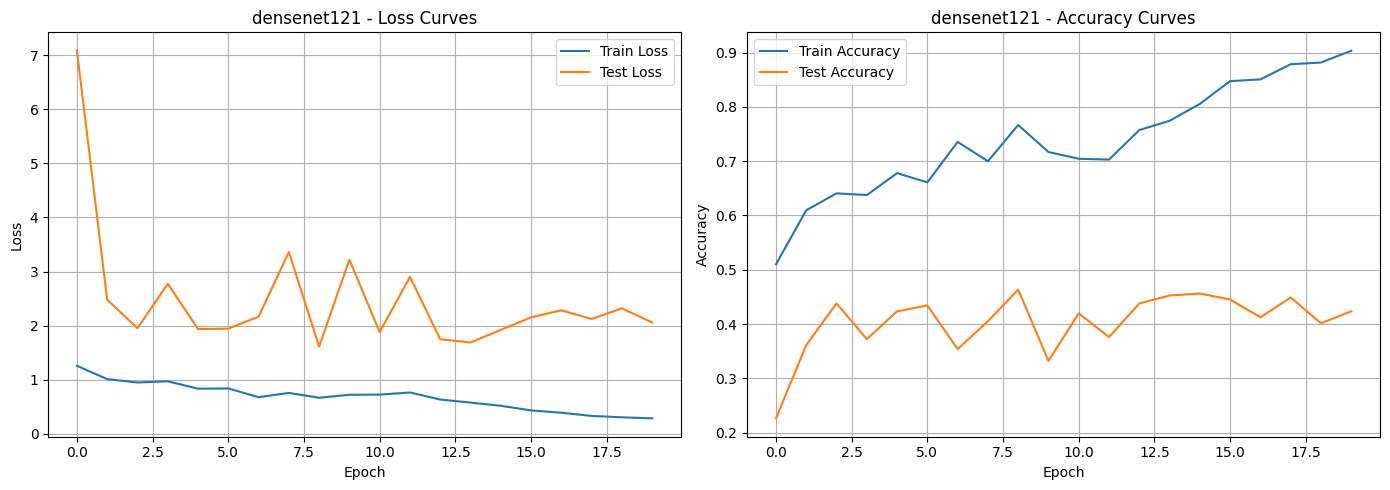


Classification Report for densenet121:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.49      0.51      0.50        45
   light_dysplastic       0.58      0.56      0.57        54
moderate_dysplastic       0.04      0.02      0.03        43
    normal_columnar       0.15      0.28      0.19        29
normal_intermediate       0.69      0.95      0.80        21
 normal_superficiel       0.94      0.70      0.80        23
  severe_dysplastic       0.38      0.31      0.34        59

           accuracy                           0.42       274
          macro avg       0.47      0.47      0.46       274
       weighted avg       0.43      0.42      0.42       274


Training RESNET50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]
Epoch 1/20: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


Epoch 1: Train Loss=1.6424, Train Acc=0.3639, Test Loss=4.0367, Test Acc=0.3248


Epoch 2/20: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]


Epoch 2: Train Loss=1.2734, Train Acc=0.5148, Test Loss=5.0621, Test Acc=0.3139


Epoch 3/20: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]


Epoch 3: Train Loss=1.2530, Train Acc=0.5210, Test Loss=2.3751, Test Acc=0.2810


Epoch 4/20: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


Epoch 4: Train Loss=1.1130, Train Acc=0.5443, Test Loss=3.0020, Test Acc=0.2993


Epoch 5/20: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 5: Train Loss=0.9957, Train Acc=0.5988, Test Loss=2.5300, Test Acc=0.3796


Epoch 6/20: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]


Epoch 6: Train Loss=0.9568, Train Acc=0.6128, Test Loss=3.4223, Test Acc=0.3759


Epoch 7/20: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


Epoch 7: Train Loss=1.0224, Train Acc=0.5785, Test Loss=2.1637, Test Acc=0.3540


Epoch 8/20: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 8: Train Loss=1.0088, Train Acc=0.5816, Test Loss=2.4934, Test Acc=0.3504


Epoch 9/20: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


Epoch 9: Train Loss=0.9546, Train Acc=0.6330, Test Loss=2.9989, Test Acc=0.3759


Epoch 10/20: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


Epoch 10: Train Loss=0.9708, Train Acc=0.5941, Test Loss=4.0193, Test Acc=0.2774


Epoch 11/20: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 11: Train Loss=0.9675, Train Acc=0.5972, Test Loss=3.2161, Test Acc=0.3321


Epoch 12/20: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


Epoch 12: Train Loss=0.7677, Train Acc=0.6827, Test Loss=1.7544, Test Acc=0.4197


Epoch 13/20: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 13: Train Loss=0.6989, Train Acc=0.7154, Test Loss=2.0358, Test Acc=0.3796


Epoch 14/20: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


Epoch 14: Train Loss=0.7023, Train Acc=0.7138, Test Loss=2.1637, Test Acc=0.3869


Epoch 15/20: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


Epoch 15: Train Loss=0.7120, Train Acc=0.7170, Test Loss=2.1587, Test Acc=0.3723


Epoch 16/20: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 16: Train Loss=0.6623, Train Acc=0.7325, Test Loss=2.5433, Test Acc=0.3686


Epoch 17/20: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


Epoch 17: Train Loss=0.6678, Train Acc=0.7263, Test Loss=2.3871, Test Acc=0.3942


Epoch 18/20: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 18: Train Loss=0.5606, Train Acc=0.7714, Test Loss=2.1936, Test Acc=0.3942


Epoch 19/20: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 19: Train Loss=0.5625, Train Acc=0.7760, Test Loss=2.2252, Test Acc=0.3577


Epoch 20/20: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]


Epoch 20: Train Loss=0.5355, Train Acc=0.7745, Test Loss=2.3765, Test Acc=0.3978


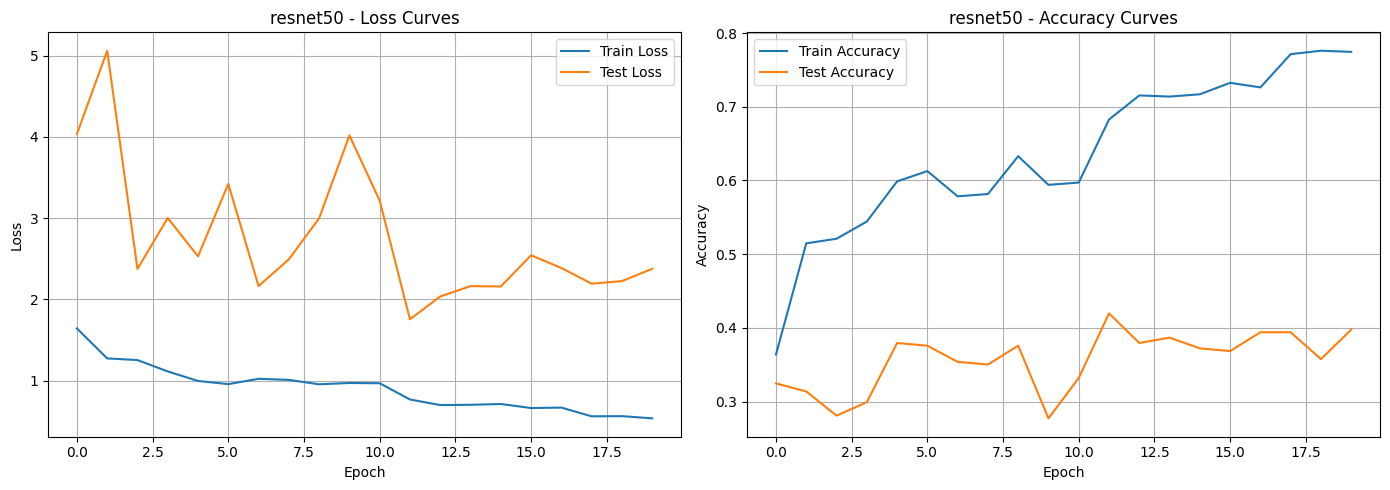


Classification Report for resnet50:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.61      0.42      0.50        45
   light_dysplastic       0.50      0.54      0.52        54
moderate_dysplastic       0.25      0.14      0.18        43
    normal_columnar       0.11      0.31      0.16        29
normal_intermediate       0.74      0.95      0.83        21
 normal_superficiel       1.00      0.74      0.85        23
  severe_dysplastic       0.25      0.15      0.19        59

           accuracy                           0.40       274
          macro avg       0.49      0.46      0.46       274
       weighted avg       0.44      0.40      0.41       274



In [14]:
# Train and evaluate baseline models
baseline_models = ['vgg16', 'densenet121', 'resnet50']
results = {}

for model_name in baseline_models:
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*60}")

    # Create and train model
    model = create_model(model_name, NUM_CLASSES)
    history, best_acc = train_model(model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE)

    # Evaluate
    preds, labels = evaluate_model(model, test_loader)

    # Store results
    results[model_name] = {
        'model': model,
        'history': history,
        'best_acc': best_acc,
        'predictions': preds,
        'labels': labels
    }

    # Plot training history
    plot_training_history(history, model_name)

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(labels, preds, target_names=list(train_dataset.class_to_idx.keys())))

In [15]:
# Compare baseline models
print("\n" + "="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)

comparison_data = []
for model_name, result in results.items():
    acc = accuracy_score(result['labels'], result['predictions'])
    precision, recall, f1, _ = precision_recall_fscore_support(
        result['labels'], result['predictions'], average='weighted'
    )
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{acc:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = max(results, key=lambda x: results[x]['best_acc'])
print(f"\nBest performing model: {best_model_name.upper()}")


BASELINE MODEL COMPARISON
      Model Accuracy Precision Recall F1-Score
      vgg16   0.3650    0.2320 0.3650   0.2564
densenet121   0.4234    0.4281 0.4234   0.4193
   resnet50   0.3978    0.4447 0.3978   0.4056

Best performing model: DENSENET121


## 5. Hybrid Model Implementation

Using ResNet50 as a fixed feature extractor + Logistic Regression classifier

In [16]:
class FeatureExtractor(nn.Module):
    """ResNet50 feature extractor (frozen weights)."""

    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        # Remove the final classification layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze all layers
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x

# Create feature extractor
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

print("Feature extractor created (ResNet50 with frozen weights)")
print(f"Output feature dimension: 2048")

Feature extractor created (ResNet50 with frozen weights)
Output feature dimension: 2048


In [17]:
def extract_features(model, dataloader):
    """Extract features from all images in a dataloader."""
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            features = model(images)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    return np.vstack(features_list), np.concatenate(labels_list)

# Extract features
print("Extracting training features...")
X_train, y_train = extract_features(feature_extractor, train_loader)

print("Extracting test features...")
X_test, y_test = extract_features(feature_extractor, test_loader)

print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Extracting training features...


Extracting features: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


Extracting test features...


Extracting features: 100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


Training features shape: (643, 2048)
Test features shape: (274, 2048)


In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized")

Features standardized


In [19]:
# Train Logistic Regression classifier
print("Training Logistic Regression classifier...")

logistic_clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=SEED,
    C=1.0
)

logistic_clf.fit(X_train_scaled, y_train)

# Predictions
hybrid_train_preds = logistic_clf.predict(X_train_scaled)
hybrid_test_preds = logistic_clf.predict(X_test_scaled)

# Evaluate
hybrid_train_acc = accuracy_score(y_train, hybrid_train_preds)
hybrid_test_acc = accuracy_score(y_test, hybrid_test_preds)

print(f"\nHybrid Model (ResNet50 + Logistic Regression) Results:")
print(f"Training Accuracy: {hybrid_train_acc:.4f}")
print(f"Test Accuracy: {hybrid_test_acc:.4f}")

Training Logistic Regression classifier...

Hybrid Model (ResNet50 + Logistic Regression) Results:
Training Accuracy: 1.0000
Test Accuracy: 0.4124



Hybrid Model Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.38      0.47      0.42        45
   light_dysplastic       0.62      0.54      0.57        54
moderate_dysplastic       0.15      0.28      0.20        43
    normal_columnar       0.56      0.17      0.26        29
normal_intermediate       0.71      0.71      0.71        21
 normal_superficiel       0.89      0.70      0.78        23
  severe_dysplastic       0.34      0.25      0.29        59

           accuracy                           0.41       274
          macro avg       0.52      0.45      0.46       274
       weighted avg       0.47      0.41      0.42       274



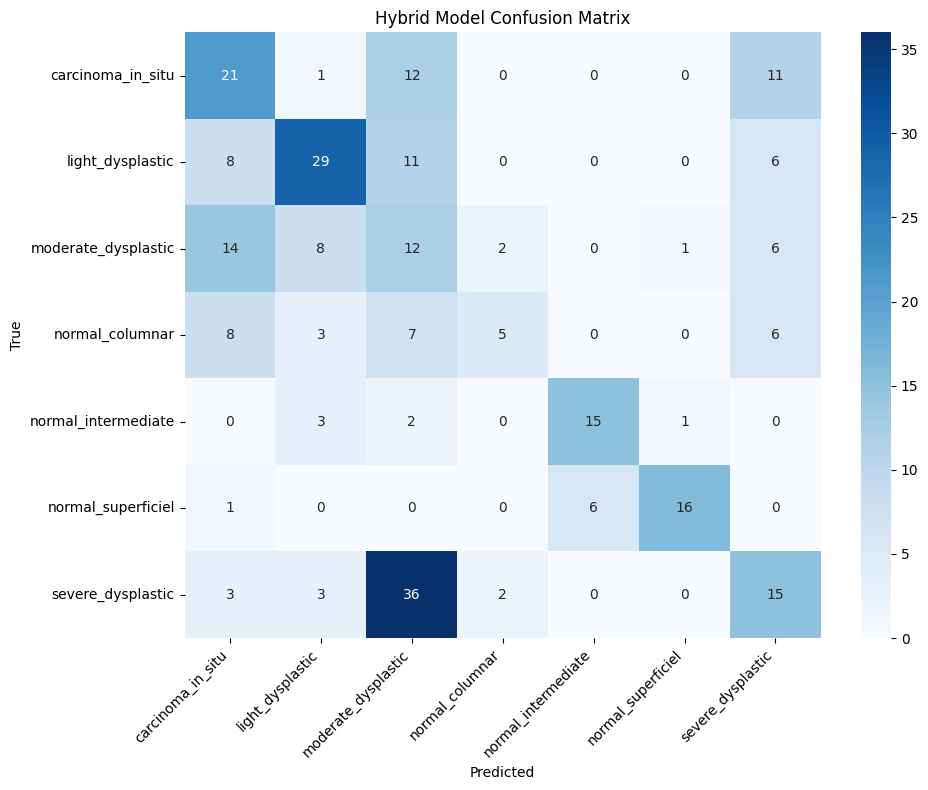

In [20]:
# Detailed evaluation of hybrid model
print("\nHybrid Model Classification Report:")
print(classification_report(y_test, hybrid_test_preds,
                           target_names=list(train_dataset.class_to_idx.keys())))

# Confusion matrix
plot_confusion_matrix(y_test, hybrid_test_preds,
                     list(train_dataset.class_to_idx.keys()),
                     "Hybrid Model Confusion Matrix")

## 6. Final Evaluation and Comparison

In [21]:
# Final comparison including hybrid model
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

final_comparison = []

# Add baseline results
for model_name, result in results.items():
    acc = accuracy_score(result['labels'], result['predictions'])
    precision, recall, f1, _ = precision_recall_fscore_support(
        result['labels'], result['predictions'], average='weighted'
    )
    final_comparison.append({
        'Model': f"{model_name} (Baseline)",
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Add hybrid model results
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, hybrid_test_preds, average='weighted'
)
final_comparison.append({
    'Model': 'ResNet50 + LogReg (Hybrid)',
    'Accuracy': hybrid_test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Create and display comparison dataframe
final_df = pd.DataFrame(final_comparison)
final_df = final_df.sort_values('Accuracy', ascending=False)

# Format for display
display_df = final_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")

print(display_df.to_string(index=False))


FINAL MODEL COMPARISON
                     Model Accuracy Precision Recall F1-Score
    densenet121 (Baseline)   0.4234    0.4281 0.4234   0.4193
ResNet50 + LogReg (Hybrid)   0.4124    0.4694 0.4124   0.4236
       resnet50 (Baseline)   0.3978    0.4447 0.3978   0.4056
          vgg16 (Baseline)   0.3650    0.2320 0.3650   0.2564


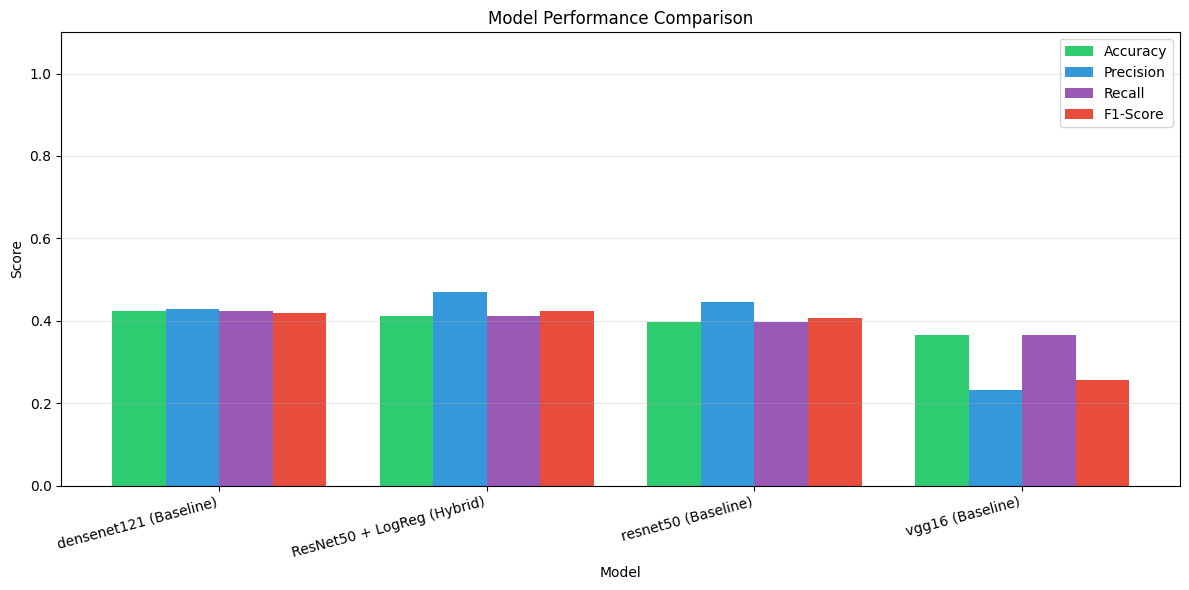

In [22]:
# Visualization of model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(final_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = final_df[metric].values
    ax.bar(x + i*width, values, width, label=metric, color=color)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(final_df['Model'].values, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. SHAP Explainability

In [23]:
# Install SHAP if needed
# !pip install shap

import shap

print("Setting up SHAP explainer...")

Setting up SHAP explainer...


In [24]:
# Create SHAP explainer for the logistic regression model
# Using a subset of training data as background
background_size = min(100, len(X_train_scaled))
background = X_train_scaled[np.random.choice(len(X_train_scaled), background_size, replace=False)]

# Create explainer
explainer = shap.LinearExplainer(logistic_clf, background)

# Calculate SHAP values for test set (using a subset for speed)
test_subset_size = min(50, len(X_test_scaled))
test_subset_idx = np.random.choice(len(X_test_scaled), test_subset_size, replace=False)
X_test_subset = X_test_scaled[test_subset_idx]

print(f"Calculating SHAP values for {test_subset_size} test samples...")
shap_values = explainer.shap_values(X_test_subset)

print("SHAP values calculated!")

Calculating SHAP values for 50 test samples...
SHAP values calculated!


<Figure size 1200x800 with 0 Axes>

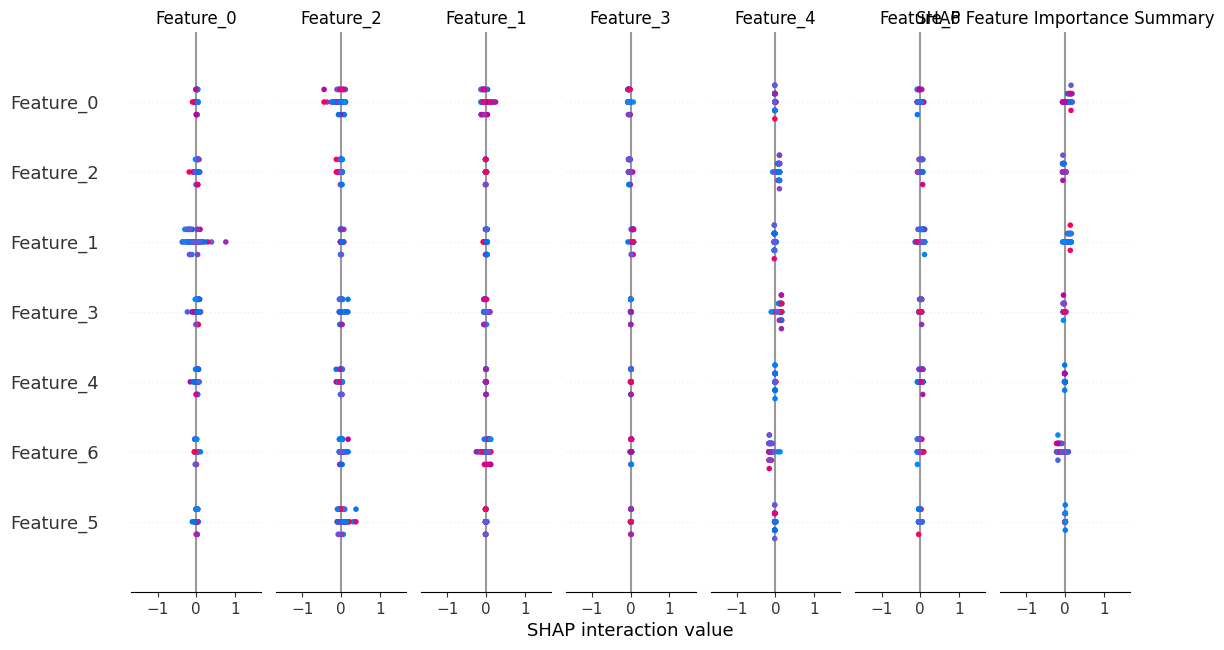

In [25]:
# Summary plot - Feature importance across all classes
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_subset,
                  feature_names=[f"Feature_{i}" for i in range(X_test_subset.shape[1])],
                  class_names=list(train_dataset.class_to_idx.keys()),
                  show=False)
plt.tight_layout()
plt.title("SHAP Feature Importance Summary")
plt.show()

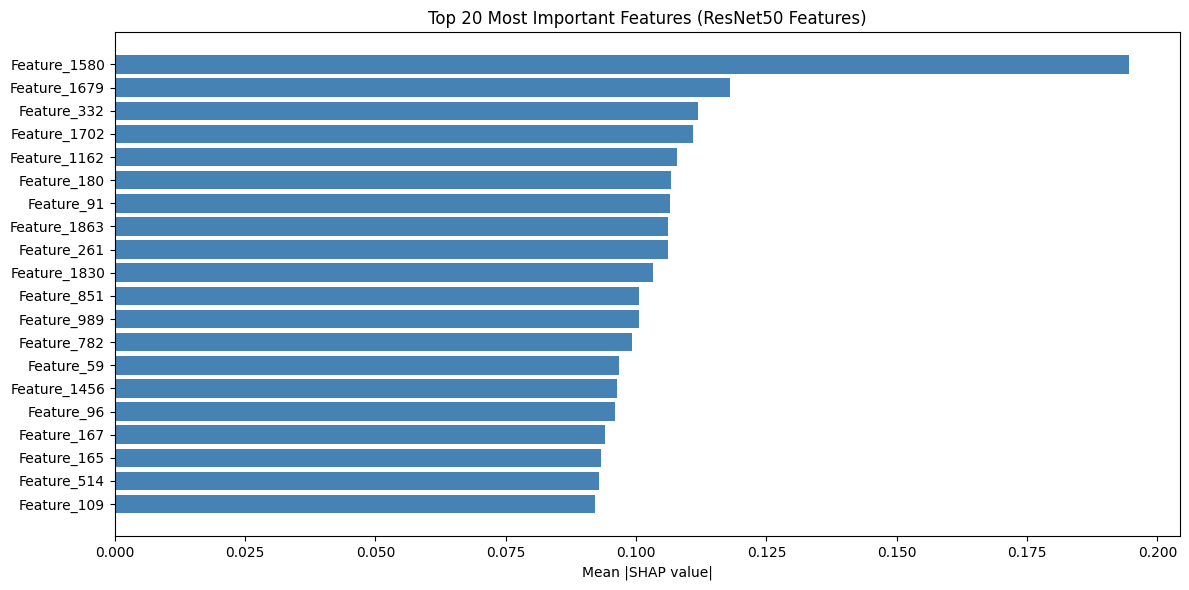

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Bar plot for mean absolute SHAP values
plt.figure(figsize=(12, 6))

# Calculate mean absolute SHAP values across all classes
# Based on the observed 'mean_shap' shape (7,) after the previous execution,
# it indicates that 'shap_values' has the structure (num_samples, num_features, num_classes).
# To get the mean absolute SHAP value per feature (2048 features), we need to average
# over the sample axis (0) and the class axis (2).
if isinstance(shap_values, list):
    # This block handles the case where shap_values is a list of (num_samples, num_features) arrays.
    # In this scenario, averaging each list item (sv) over axis 0 results in (num_features,),
    # and then averaging across the list (axis 0 of the list of arrays) yields the final (num_features,) array.
    mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    # This block handles the case where shap_values is a single 3D array.
    # Assuming shap_values is (num_samples, num_features, num_classes).
    # To get mean absolute SHAP per feature, average over samples (axis 0) and classes (axis 2).
    mean_shap = np.abs(shap_values).mean(axis=(0, 2)) # Corrected: average over samples (0) and classes (2)

# Get top 20 most important features
top_k = 20

# Ensure mean_shap is 1D before arg_sorting for feature importance
# This check is a safeguard, but with the corrected calculation, mean_shap should already be 1D.
if mean_shap.ndim > 1:
    # If for some reason mean_shap is still 2D (e.g., (num_features, 1) or (1, num_features)),
    # squeeze it to 1D. This scenario should ideally not be reached with the above fix.
    mean_shap = np.squeeze(mean_shap)

# Now, mean_shap should be a 1D array of shape (num_features,).
# top_indices will then select the indices of the top_k features.
top_indices = np.argsort(mean_shap)[-top_k:]

plt.barh(range(top_k), mean_shap[top_indices], color='steelblue')
plt.yticks(range(top_k), [f"Feature_{i}" for i in top_indices])
plt.xlabel('Mean |SHAP value|')
plt.title(f'Top {top_k} Most Important Features (ResNet50 Features)')
plt.tight_layout()
plt.show()

In [32]:
# Individual prediction explanation
def explain_prediction(idx, X_test_subset, y_test_subset, shap_values, class_names):
    """Explain a single prediction using SHAP."""

    true_label = y_test_subset[idx]
    pred_label = logistic_clf.predict(X_test_subset[idx:idx+1])[0]

    print(f"Sample {idx}:")
    print(f"  True class: {class_names[true_label]}")
    print(f"  Predicted class: {class_names[pred_label]}")
    print(f"  Correct: {true_label == pred_label}")

    # Force plot for predicted class
    if isinstance(shap_values, list):
        # This handles the case where shap_values is a list of (num_samples, num_features) arrays.
        # sv = shap_values[pred_label][idx]
        # The original code's issue is specific to the 'else' block's handling of 3D array.
        # This part of the code might also need correction if `shap_values` were a list in practice.
        # Given kernel state, `shap_values` is an ndarray.
        # For now, we assume this 'if' path isn't taken, or if it is, `shap_values[pred_label]` already gives the correct shape.
        sv = shap_values[pred_label][idx]
    else:
        # This handles the case where shap_values is a single 3D array of shape (num_samples, num_features, num_classes).
        # We need the SHAP values for the specific sample (idx) and the specific predicted class (pred_label).
        sv = shap_values[idx, :, pred_label] # Correctly extract 1D SHAP values for the predicted class

    # Remove matplotlib=True to allow default interactive rendering
    shap.force_plot(explainer.expected_value[pred_label] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
                   sv, X_test_subset[idx])

# Explain a few predictions
y_test_subset = y_test[test_subset_idx]
class_names = list(train_dataset.class_to_idx.keys())

for i in range(3):
    explain_prediction(i, X_test_subset, y_test_subset, shap_values, class_names)
    print()

Sample 0:
  True class: carcinoma_in_situ
  Predicted class: severe_dysplastic
  Correct: False

Sample 1:
  True class: light_dysplastic
  Predicted class: light_dysplastic
  Correct: True

Sample 2:
  True class: severe_dysplastic
  Predicted class: moderate_dysplastic
  Correct: False



## 8. Save Models and Results

In [33]:
import pickle

# Create models directory
MODELS_DIR = "./saved_models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Save feature extractor
torch.save(feature_extractor.state_dict(), os.path.join(MODELS_DIR, "resnet50_feature_extractor.pth"))

# Save logistic regression model and scaler
with open(os.path.join(MODELS_DIR, "logistic_classifier.pkl"), 'wb') as f:
    pickle.dump(logistic_clf, f)

with open(os.path.join(MODELS_DIR, "scaler.pkl"), 'wb') as f:
    pickle.dump(scaler, f)

# Save class mapping
with open(os.path.join(MODELS_DIR, "class_mapping.pkl"), 'wb') as f:
    pickle.dump(train_dataset.class_to_idx, f)

# Save results
final_df.to_csv(os.path.join(MODELS_DIR, "model_comparison_results.csv"), index=False)

print(f"Models and results saved to {MODELS_DIR}")

Models and results saved to ./saved_models


## 9. Streamlit Dashboard

Run the following code to create a Streamlit dashboard file:

In [34]:
streamlit_code = '''
"""
Cervical Cancer Cell Classification Dashboard
Project Phoenix - Streamlit Application

Run with: streamlit run streamlit_app.py
"""

import streamlit as st
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pickle
import os

# Page configuration
st.set_page_config(
    page_title="Project Phoenix - Cell Classification",
    page_icon="🔬",
    layout="wide"
)

# Constants
IMG_SIZE = 224
MODELS_DIR = "./saved_models"

# Load models
@st.cache_resource
def load_models():
    """Load the feature extractor and classifier."""

    # Feature extractor
    class FeatureExtractor(nn.Module):
        def __init__(self):
            super(FeatureExtractor, self).__init__()
            resnet = models.resnet50(weights=None)
            self.features = nn.Sequential(*list(resnet.children())[:-1])

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            return x

    device = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')

    feature_extractor = FeatureExtractor()
    feature_extractor.load_state_dict(torch.load(
        os.path.join(MODELS_DIR, "resnet50_feature_extractor.pth"),
        map_location=device
    ))
    feature_extractor.eval()
    feature_extractor.to(device)

    # Classifier and scaler
    with open(os.path.join(MODELS_DIR, "logistic_classifier.pkl"), \'rb\') as f:
        classifier = pickle.load(f)

    with open(os.path.join(MODELS_DIR, "scaler.pkl"), \'rb\') as f:
        scaler = pickle.load(f)

    with open(os.path.join(MODELS_DIR, "class_mapping.pkl"), \'rb\') as f:
        class_mapping = pickle.load(f)

    return feature_extractor, classifier, scaler, class_mapping, device

# Image preprocessing
def preprocess_image(image):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# Prediction function
def predict(image, feature_extractor, classifier, scaler, class_mapping, device):
    """Make prediction on an image."""

    # Preprocess
    img_tensor = preprocess_image(image).to(device)

    # Extract features
    with torch.no_grad():
        features = feature_extractor(img_tensor).cpu().numpy()

    # Scale and predict
    features_scaled = scaler.transform(features)
    prediction = classifier.predict(features_scaled)[0]
    probabilities = classifier.predict_proba(features_scaled)[0]

    # Get class names
    idx_to_class = {v: k for k, v in class_mapping.items()}

    return idx_to_class[prediction], probabilities, idx_to_class

# Main app
def main():
    st.title("🔬 Project Phoenix")
    st.subheader("Cervical Cancer Cell Classification")
    st.markdown("---")

    # Sidebar
    st.sidebar.title("About")
    st.sidebar.info(
        "This application uses a hybrid deep learning model "
        "(ResNet50 + Logistic Regression) to classify cervical cells "
        "into 7 categories based on the Herlev dataset."
    )

    st.sidebar.title("Cell Classes")
    st.sidebar.markdown("""
    - Carcinoma in situ
    - Light dysplastic
    - Moderate dysplastic
    - Normal columnar
    - Normal intermediate
    - Normal superficial
    - Severe dysplastic
    """)

    # Load models
    try:
        feature_extractor, classifier, scaler, class_mapping, device = load_models()
        st.success("Models loaded successfully!")
    except Exception as e:
        st.error(f"Error loading models: {e}")
        st.stop()

    # File upload
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("Upload Cell Image")
        uploaded_file = st.file_uploader(
            "Choose an image...",
            type=[\'bmp\', \'png\', \'jpg\', \'jpeg\']
        )

        if uploaded_file is not None:
            image = Image.open(uploaded_file).convert(\'RGB\')
            st.image(image, caption="Uploaded Image", use_column_width=True)

    with col2:
        st.subheader("Classification Results")

        if uploaded_file is not None:
            if st.button("Classify", type="primary"):
                with st.spinner("Analyzing..."):
                    pred_class, probs, idx_to_class = predict(
                        image, feature_extractor, classifier, scaler, class_mapping, device
                    )

                # Display prediction
                st.success(f"**Predicted Class:** {pred_class.replace(\'_\', \' \').title()}")

                # Probability chart
                st.subheader("Class Probabilities")
                prob_data = {
                    idx_to_class[i].replace(\'_\', \' \').title(): probs[i]
                    for i in range(len(probs))
                }
                st.bar_chart(prob_data)

                # Risk assessment
                abnormal_classes = [\'carcinoma_in_situ\', \'light_dysplastic\',
                                   \'moderate_dysplastic\', \'severe_dysplastic\']

                if pred_class in abnormal_classes:
                    st.warning("⚠️ **Abnormal cell detected.** Please consult a medical professional.")
                else:
                    st.info("✅ Cell appears normal.")
        else:
            st.info("Please upload an image to classify.")

    # Footer
    st.markdown("---")
    st.markdown(
        "**Disclaimer:** This tool is for research purposes only. "
        "Always consult qualified medical professionals for diagnosis."
    )

if __name__ == "__main__":
    main()
'''

# Save streamlit app
with open("streamlit_app.py", 'w') as f:
    f.write(streamlit_code)

print("Streamlit dashboard saved as 'streamlit_app.py'")
print("\nTo run the dashboard:")
print("  1. Install streamlit: pip install streamlit")
print("  2. Run: streamlit run streamlit_app.py")

Streamlit dashboard saved as 'streamlit_app.py'

To run the dashboard:
  1. Install streamlit: pip install streamlit
  2. Run: streamlit run streamlit_app.py


## 10. Summary

### Key Findings:

1. **Data**: Successfully loaded and preprocessed the Herlev dataset with 7 cell classes

2. **Baseline Models**: Evaluated VGG16, DenseNet121, and ResNet50 as standalone classifiers

3. **Hybrid Model**: Implemented ResNet50 (frozen) + Logistic Regression which minimizes overfitting risk

4. **Explainability**: Added SHAP analysis to understand feature importance

5. **Dashboard**: Created Streamlit app for easy deployment and use

### Files Generated:
- `saved_models/resnet50_feature_extractor.pth` - Feature extractor weights
- `saved_models/logistic_classifier.pkl` - Trained classifier
- `saved_models/scaler.pkl` - Feature scaler
- `saved_models/class_mapping.pkl` - Class name mapping
- `saved_models/model_comparison_results.csv` - Performance comparison
- `streamlit_app.py` - Interactive dashboard

In [ ]:
print("\n" + "="*60)
print("PIPELINE COMPLETE")
print("="*60)
print("\nAll steps successfully implemented:")
print("  ✓ Data loading and preparation")
print("  ✓ Baseline model evaluation (VGG16, DenseNet121, ResNet50)")
print("  ✓ Hybrid model implementation (ResNet50 + Logistic Regression)")
print("  ✓ Final evaluation and comparison")
print("  ✓ SHAP explainability")
print("  ✓ Streamlit dashboard")